In [1]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
IMG_SIZE = 224
NUM_EPOCHS = 100
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

In [3]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
train_generator = data_generator_with_aug.flow_from_directory(
            'data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
validation_generator = data_generator_with_aug.flow_from_directory(
            'data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [4]:
model_name_vgg16 = "vgg16.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_vgg16, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [5]:
def vgg16_pretrained(lr=1e-3):
    my_new_model = Sequential()
    vgg_weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg= VGG16(include_top=False, weights=vgg_weights_path ) 
    vgg.summary()
    my_new_model.add(vgg)
    my_new_model.add(GlobalAveragePooling2D())
    my_new_model.layers[0].trainable = False
    my_new_model.layers[1].trainable = False
    #my_new_model.add(Dense(4096, activation='relu'))  
    my_new_model.add(Dense(4096, activation='relu'))
    my_new_model.add(Dense(1000, activation='relu'))      
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))
    my_new_model.compile(optimizer = Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return my_new_model

In [6]:
def resnet50_pretrained(lr=1e-3):
    my_new_model = Sequential()
    
    resnet = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path)
    my_new_model.add(resnet)
    my_new_model.layers[0].trainable = False
    my_new_model.add(Dense(1000, activation='relu'))      
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [7]:
def vgg16(ishape=(IMG_SIZE,IMG_SIZE,3), drop=0.1, lr=1e-3):
    out_layers = 64
    input_img = Input(shape=ishape)
    x = Conv2D(out_layers, (3,3), activation="relu", padding="same")(input_img)
    x = Conv2D(out_layers, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*2, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*2, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*4, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*4, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*4, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = GlobalMaxPooling2D()(x)
    #x = Dense(4096, activation="relu")(x)
    x = Dropout(rate=drop)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(rate=drop)(x)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(rate=drop)(x)
    x = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer = Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [8]:
model = vgg16_pretrained()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [9]:
history = model.fit(train_generator, epochs = NUM_EPOCHS, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(validation_generator))

Epoch 1/100
22/22 [==============================] - 62s 3s/step - loss: 7.0276 - accuracy: 0.5268 - val_loss: 1.0781 - val_accuracy: 0.5380
Epoch 2/100
22/22 [==============================] - 63s 3s/step - loss: 0.2434 - accuracy: 0.9017 - val_loss: 1.3191 - val_accuracy: 0.4737
Epoch 3/100
22/22 [==============================] - 63s 3s/step - loss: 0.1788 - accuracy: 0.9288 - val_loss: 0.8555 - val_accuracy: 0.6784
Epoch 4/100
22/22 [==============================] - 64s 3s/step - loss: 0.1570 - accuracy: 0.9497 - val_loss: 0.6800 - val_accuracy: 0.7544
Epoch 5/100
22/22 [==============================] - 64s 3s/step - loss: 0.1240 - accuracy: 0.9540 - val_loss: 0.6769 - val_accuracy: 0.7368
Epoch 6/100
22/22 [==============================] - 67s 3s/step - loss: 0.0886 - accuracy: 0.9655 - val_loss: 0.7308 - val_accuracy: 0.7602
Epoch 7/100
22/22 [==============================] - 67s 3s/step - loss: 0.0585 - accuracy: 0.9843 - val_loss: 0.7542 - val_accuracy: 0.7368
Epoch 8/100
2

In [10]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

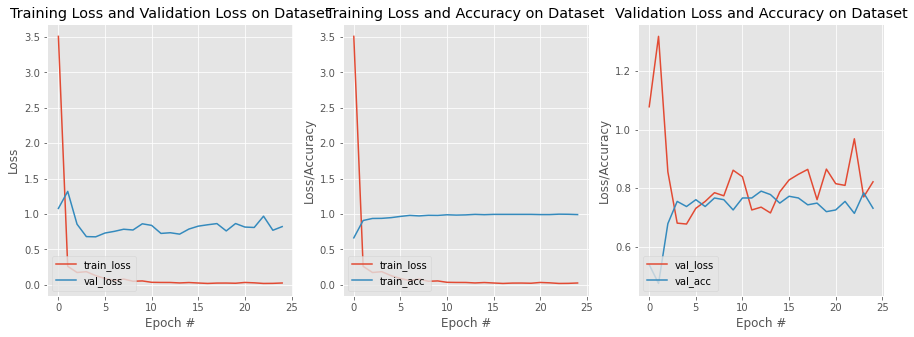

In [12]:
plot_history(history,25)